In [37]:
"""
This notebook creates a Bayesian structural time series model to estimate the total bike ride demand
across multiple years. This can then be used for prediction.
"""

import glob
import os

import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc as pm

from scipy.ndimage import gaussian_filter
from scipy.stats import nbinom

# File name for the final model results
MODEL_RESULTS_FILE = "../models/time_series.nc"

In [38]:
# Load in the data
df_bike = pd.read_pickle("../data/indego_bike_data.pkl")
print(df_bike.head())

       trip_id  duration           start_time             end_time  \
0  144361832.0      12.0  2017-07-01 00:04:00  2017-07-01 00:16:00   
1  144361829.0      31.0  2017-07-01 00:06:00  2017-07-01 00:37:00   
2  144361830.0      15.0  2017-07-01 00:06:00  2017-07-01 00:21:00   
3  144361831.0      15.0  2017-07-01 00:06:00  2017-07-01 00:21:00   
4  144361828.0      30.0  2017-07-01 00:07:00  2017-07-01 00:37:00   

   start_station  start_lat  start_lon  end_station    end_lat    end_lon  \
0         3160.0  39.956619 -75.198624       3163.0  39.949741 -75.180969   
1         3046.0  39.950119 -75.144722       3101.0  39.942951 -75.159554   
2         3006.0  39.952202  -75.20311       3101.0  39.942951 -75.159554   
3         3006.0  39.952202  -75.20311       3101.0  39.942951 -75.159554   
4         3046.0  39.950119 -75.144722       3101.0  39.942951 -75.159554   

  bike_id  plan_duration trip_route_category passholder_type bike_type  
0   11883           30.0             One Wa

So far, I modeled two aspects of bike ride demand: Ride duration and the # number of bike rides per
station for each weekday. But now, I'm curious as to a more high level metric: The *total* number of
bike rides per weekday.

First, I do want to note that while one could just aggregate the sum of rides from all bike stations 
per weekday, this would not be as valid as creating a separate time series model. This model just
aggregates all the Mondays together, all the Tuesdays together, etc., but it has no concept whether
say, a Monday in 2025 is more busy than a Monday in 2023; Each instance of a weekday would be 
considered identical.

The time series model though, can highlight such a possible trend. It focuses on the long-term 
growth or decline on the entire system's ridership, whcih is the most impactful factor for accurate
forecasting. This is also more statistically efficient since the model is built to predict a single 
bike ride count, not multiple bike ride counts. 

With that said, this model is using a Gaussian Random Walk, meaning that the bike ride demand trend
for any given data is assumed to be the same as the previous day, +/- a small random change. This 
allows the model to learn a smooth trend (since it is very unlikely, if at all present, that demamd
would either spike up or down quickly). Given the cyclical nature of weekdays, the model can also 
learn a stable, repeating 7-day cycle for how people use the bikes. This estimates a single, fixed 
effect for every Monday, Tuesday, etc. Finally, by combining the overall trend with the weekday 
effect, a final prediction can be made. This prediction is then combined with the actual data with 
a Negative Binomial likelihood*.

*The Negative Binomial likelihood is chosen as a more flexible and robust alternative to the Poisson
distribution for modeling count data. Most notably, it can handle overdispersion (the Poisson
distribution assumes mean and variance are equal in a dataset), but in the bike data, this likely
would be violated.

In [39]:
# For simplicity, subset to the last two years
df_bike["start_time"] = pd.to_datetime(df_bike["start_time"], format="mixed")
latest_date = df_bike["start_time"].max()
cutoff_date = latest_date - pd.DateOffset(years=2)
df_bike = df_bike[df_bike["start_time"] >= cutoff_date].copy()

# Set 'start_time' as the index and resample to get daily counts
df_daily_rides = df_bike.set_index("start_time").resample("D").size()

# Create a day of the week feature for the seasonality component
day_of_week = df_daily_rides.index.dayofweek

# Convert to numpy values into int64
day_of_week = day_of_week.values.astype("int64")

print(df_daily_rides.head())

start_time
2023-06-30       7
2023-07-01    3227
2023-07-02    2706
2023-07-03    2916
2023-07-04    3115
Freq: D, dtype: int64


In [41]:
n_days_total = len(df_daily_rides)
n_days_week = 7

with pm.Model() as ts_model:
    # --- Weekly Seasonality ---
    # An effect for each day of the week; Normal distribution as a safe choice
    week_effect = pm.Normal("week_effect", mu=0, sigma=0.05, shape=n_days_week)

    # --- Trend Component (Gaussian Random Walk) ---
    # Initialize as a normal distribution as a safe choice; Log scale used to reduce range of values
    trend = pm.GaussianRandomWalk(
        "trend",
        mu=0,
        sigma=0.1,
        shape=n_days_total,
        init_dist=pm.Normal.dist(mu=np.log(df_daily_rides.iloc[0]), sigma=1),
    )

    # --- Expected Ride Count ---
    # The expected rate is the combination of the trend and the weekly effect
    # for that day, converted from log scale
    expected_count = pm.math.exp(trend + week_effect[day_of_week])

    # --- Likelihood ---
    # NegativeBinomial chosen as it is often more flexible for count data than a Poisson
    # as it can handle overdispersion (more variance than the mean)
    alpha = pm.HalfNormal("alpha", sigma=50)
    y_obs = pm.NegativeBinomial(
        "y_obs", mu=expected_count, alpha=alpha, observed=df_daily_rides.values
    )

    # --- MCMC Sampling ---
    # NOTE: Number of draws is smaller than I would've liked, but this ensures the model file is not
    # super large
    idata_ts = pm.sample(750, tune=1000, cores=12, progressbar=True)

# Save the final results to a file for later use
print("\n--- Saving Model Results ---")
idata_ts.to_netcdf(MODEL_RESULTS_FILE)
print(f"Model results saved to {MODEL_RESULTS_FILE}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [week_effect, trend, alpha]


Sampling 12 chains for 1_000 tune and 750 draw iterations (12_000 + 9_000 draws total) took 62 seconds.



--- Saving Model Results ---
Model results saved to ../models/time_series.nc


From the model, I can decompose the historical data into the trend and historical components.

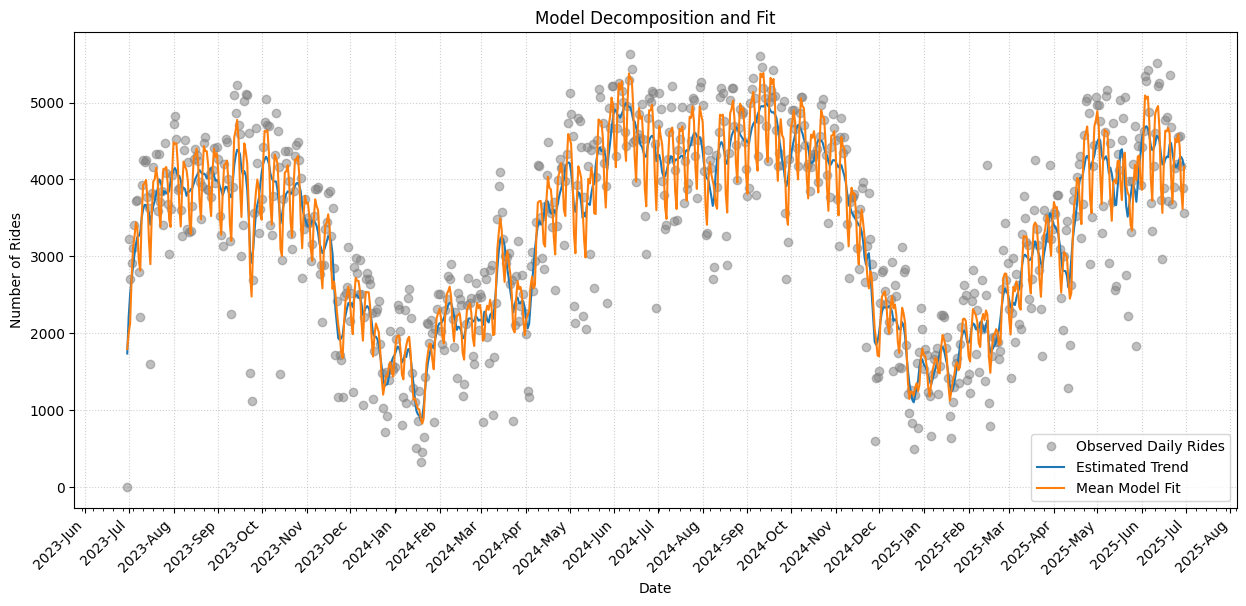

In [42]:
# Extract the posterior mean for the trend and the full model fit
posterior_samples = az.extract(idata_ts)
mean_log_trend = posterior_samples["trend"].mean(dim="sample").values
mean_fit = np.exp(
    mean_log_trend
    + posterior_samples["week_effect"].mean(dim="sample").values[day_of_week]
)

# Convert the trend back to the original scale
mean_trend_original_scale = np.exp(mean_log_trend)

# Create the figure and axes object (required for tick customization)
fig, ax = plt.subplots(figsize=(15, 7))

# Plotting using the axes object
ax.plot(
    df_daily_rides.index,
    df_daily_rides.values,
    "o",
    color="gray",
    alpha=0.5,
    label="Observed Daily Rides",
)
ax.plot(
    df_daily_rides.index, mean_trend_original_scale, color="C0", label="Estimated Trend"
)
ax.plot(df_daily_rides.index, mean_fit, color="C1", label="Mean Model Fit")

# Date tick adjustements for clarity
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b"))  #
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
fig.autofmt_xdate(rotation=45, ha="right")

# Final bit of formatting
ax.set_title("Model Decomposition and Fit")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")
ax.legend()
ax.grid(True, linestyle=":", alpha=0.6)

plt.show()

A clear seasonal trend can be seen here. In particular, a dip in bike ride demand during the fall 
and winter months, with activity spiking back up during the spring and summer. 

Note that the plot displays three things. First, I display the raw counts for daily rides, and while
there is a trend, it's quite noisy. Meanwhile, the blue line represents the estimated trend, which
is the baseline level of bike ride demand. But, this does not include the weekly seasonality noted 
from the previous notebook - the orange line for the mean model fit, *does* include this weekly
seasonality. One can see how the baseline trend is less spiky and more smooth compared to the actual
mean model fit.

One thing to notice is the spiky nature of the graph. This is mainly due to the decrease in activity
between weekdays and weekends, but it does make the trend a little hard to see. So, I apply a
technique called Gaussian smoothing to smooth out the graph, but still maintain the main trend 
patterns.

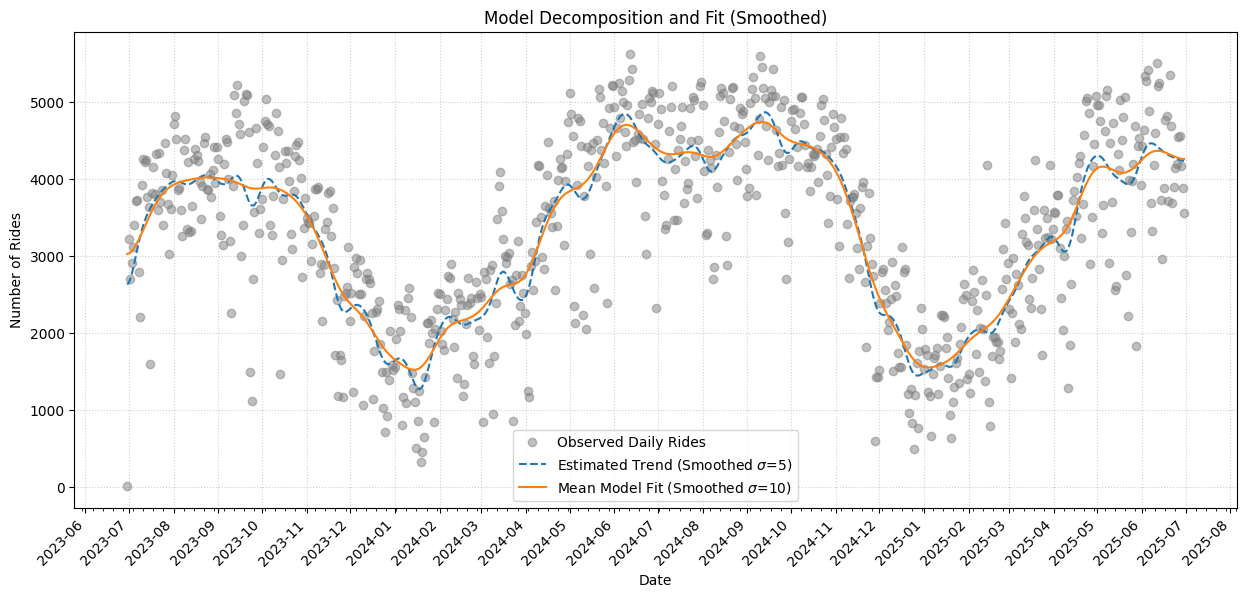

In [43]:
SMOOTHING_SIGMA_TREND = 5
SMOOTHING_SIGMA_FIT = 10

# Apply Gaussian smoothing to the trend
smoothed_trend = gaussian_filter(
    input=mean_trend_original_scale, sigma=SMOOTHING_SIGMA_TREND, mode="reflect"
)

# Apply Gaussian smoothing to the mean fit
smoothed_fit = gaussian_filter(
    input=mean_fit, sigma=SMOOTHING_SIGMA_FIT, mode="reflect"
)

# Create the plot figure and axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Plotting
ax.plot(
    df_daily_rides.index,
    df_daily_rides.values,
    "o",
    color="gray",
    alpha=0.5,
    label="Observed Daily Rides",
)
ax.plot(
    df_daily_rides.index,
    smoothed_trend,
    color="C0",
    linestyle="--",
    label=f"Estimated Trend (Smoothed $\\sigma$={SMOOTHING_SIGMA_TREND})",
)
ax.plot(
    df_daily_rides.index,
    smoothed_fit,
    color="C1",
    label=f"Mean Model Fit (Smoothed $\\sigma$={SMOOTHING_SIGMA_FIT})",
)

# Apply formatting to date axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
fig.autofmt_xdate(rotation=45, ha="right")
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))

# Final plot formatting
ax.set_title("Model Decomposition and Fit (Smoothed)")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")
ax.legend()
ax.grid(True, linestyle=":", alpha=0.6)
plt.show()

This helps to show a more smooth version of the data, which may be easier to see. One thing that is
more visible here, is that there appears to be more ridership in 2024 compared to 2023.

Anyways, what about the forecast of future ridership (aka why the model was mainly built to begin
with)? I show this by forecasting the next 30 days of ridership. 

This works by taking the structured
time series model based on the posterior data, and running a manual simulation (a forward walk). For each sample, it applies the known seasonal effect for each day of the week, then it applies a new random step to the trend, and then finally generating a final count with the Negative Binomial distribution.

This results in many simulated unique future paths, and the mean forecast is the average of these paths.

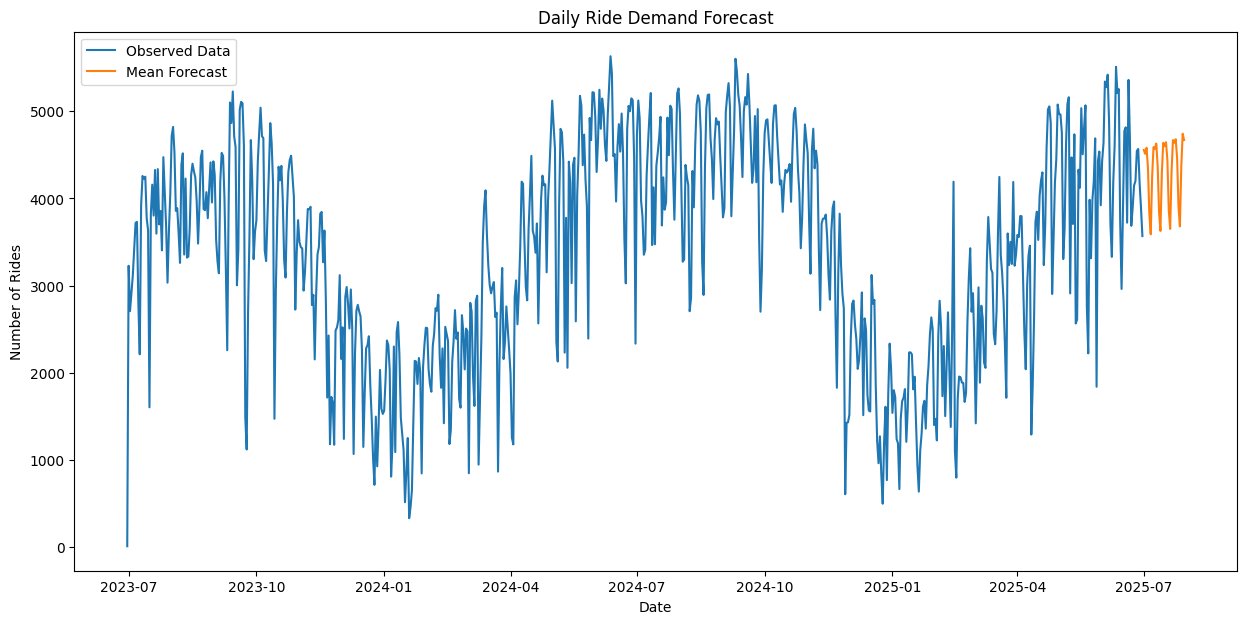

In [44]:
# Extract the full posterior dataset
posterior_samples = az.extract(
    idata_ts
)  # Convert InferenceData to a convenient xarray Dataset.

# --- Extract each variable using its name ---
# Isolate the trend value from the last observed day.
last_day_trend = posterior_samples["trend"].isel(trend_dim_0=-1)
# Posterior distribution for the weekly seasonality.
week_effect_samples = posterior_samples["week_effect"]
# Dispersion parameter for the Negative Binomial distribution.
alpha_samples = posterior_samples["alpha"]
# Standard deviation for the random walk step (same fixed value as what was used in the TS model)
trend_sigma = 0.05

# Define n_samples
n_samples = len(last_day_trend)

# Manually Simulate the Forecast
n_forecast_days = 30
forecast_dates = pd.date_range(
    start=df_daily_rides.index[-1] + pd.Timedelta(days=1), periods=n_forecast_days
)
forecast_day_of_week = forecast_dates.dayofweek

# Initialize array to store N complete forecast paths.
forecast_values = np.zeros((n_samples, n_forecast_days))

# Loop through each posterior sample to create a full distribution of forecasts
for i in range(n_samples):
    current_trend = last_day_trend.isel(
        sample=i
    ).values  # Trend starting point for this sample's forecast path.
    current_week_effect_sample = week_effect_samples.isel(sample=i).values
    current_alpha_sample = alpha_samples.isel(sample=i).values

    for t in range(n_forecast_days):
        # Apply a random walk step to the trend
        current_trend += np.random.normal(0, trend_sigma)

        day_effect = current_week_effect_sample[forecast_day_of_week[t]]
        # Calculate the expected mean (lambda/mu) on the original scale
        expected_count = np.exp(current_trend + day_effect)

        # NOTE: The nbinom.rvs function needs p, not mu and alpha. Convert to p with mu and alpha
        # Negative Binomial parameter conversion: p = mu / (mu + alpha)
        p = expected_count / (expected_count + current_alpha_sample)
        # Sample the final count using the Negative Binomial distribution
        forecast_values[i, t] = nbinom.rvs(n=current_alpha_sample, p=1 - p)

# Plot the Forecast
plt.figure(figsize=(15, 7))
plt.plot(df_daily_rides.index, df_daily_rides.values, label="Observed Data")
# Plot the mean forecast
plt.plot(
    forecast_dates, forecast_values.mean(axis=0), color="C1", label="Mean Forecast"
)  # Plot the average (expected value) of all forecast paths.

# Final formatting changes
plt.title("Daily Ride Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Rides")
plt.legend()
plt.show()

Not too surprising, the forecast predicts a small spike in bike demand. However, notice that the
prediction is consistent within itself - this is expected for this model.